## Step A

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import collections

In [10]:
query_imgs = ['0', '1', '11', '19', '24', '25', '26']
train_imgs = ['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png']
true_imgs = {
    'e1.png':{'0','11'},
    'e2.png':{'24','25','26'},
    'e3.png':{'0','1','11'},
    'e4.png':{'0','11','25','26'},
    'e5.png':{'19','25'},
}
sorted_true_imgs = collections.OrderedDict(sorted(true_imgs.items()))

In [11]:
LOWE_COEFF = 0.5
MIN_MATCH_COUNT = 30
COLOR_T = 50
COLORS = False

Scene: e1.png

Product 0 – 1/1 instances found
	Position: (162, 214)	Width: 310	Height: 432
Product 1 – 0/0 instances found
Product 11 – 1/1 instances found
	Position: (443, 167)	Width: 299	Height: 389
Product 19 – 0/0 instances found
Product 24 – 0/0 instances found
Product 25 – 0/0 instances found
Product 26 – 0/0 instances found


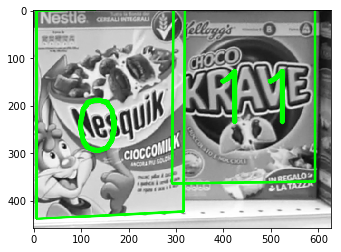



Scene: e2.png

Product 0 – 0/0 instances found
Product 1 – 0/0 instances found
Product 11 – 0/0 instances found
Product 19 – 0/0 instances found
Product 24 – 1/1 instances found
	Position: (167, 219)	Width: 334	Height: 489
Product 25 – 1/1 instances found
	Position: (878, 233)	Width: 313	Height: 443
Product 26 – 1/1 instances found
	Position: (538, 218)	Width: 333	Height: 486


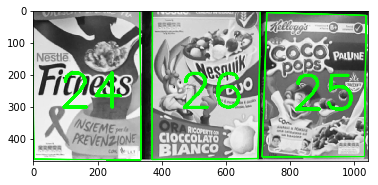



Scene: e3.png

Product 0 – 1/1 instances found
	Position: (170, 236)	Width: 324	Height: 439
Product 1 – 0/1 instances found
Product 11 – 1/1 instances found
	Position: (474, 191)	Width: 303	Height: 394
Product 19 – 0/0 instances found
Product 24 – 0/0 instances found
Product 25 – 0/0 instances found
Product 26 – 0/0 instances found


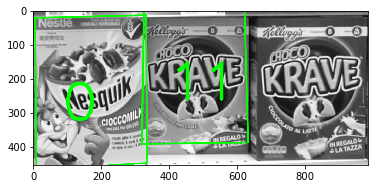



Scene: e4.png

Product 0 – 1/1 instances found
	Position: (158, 739)	Width: 324	Height: 439
Product 1 – 0/0 instances found
Product 11 – 1/1 instances found
	Position: (463, 691)	Width: 303	Height: 396
Product 19 – 0/0 instances found
Product 24 – 0/0 instances found
Product 25 – 1/1 instances found
	Position: (556, 281)	Width: 359	Height: 586
Product 26 – 1/1 instances found
	Position: (205, 195)	Width: 341	Height: 493


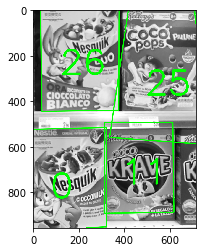



Scene: e5.png

Product 0 – 0/0 instances found
Product 1 – 0/0 instances found
Product 11 – 0/0 instances found
Product 19 – 1/1 instances found
	Position: (503, 190)	Width: 295	Height: 384
Product 24 – 0/0 instances found
Product 25 – 1/1 instances found
	Position: (161, 228)	Width: 321	Height: 447
Product 26 – 0/0 instances found


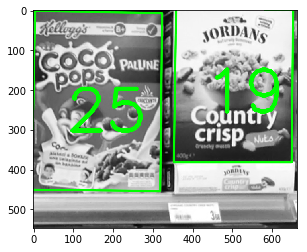

In [12]:
sift = cv2.xfeatures2d.SIFT_create()


for train_img in train_imgs:
    
    print('Scene: ' + train_img + '\n')

    train_file = 'scenes/' + train_img
    
    train = cv2.imread(train_file, 0)
    train_bgr = cv2.imread(train_file)
    
    if COLORS == True:
        train3 = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2RGB)
        train_rgb = np.zeros(train_bgr.shape, train_bgr.dtype)
        for y in range(train3.shape[0]):
            for x in range(train3.shape[1]):
                for c in range(train3.shape[2]):
                    train_rgb[y,x,c] = np.clip(0.5*train3[y,x,c], 0, 255)             
    else:        
        train_rgb = cv2.cvtColor(train, cv2.COLOR_GRAY2RGB)
       
    kp_train, des_train = sift.detectAndCompute(train, None)
    
    global_matches = {}
    recognised = {}
    
    
    for query_img in query_imgs:
        
        query_file = 'models/' + query_img + '.jpg'
        query = cv2.imread(query_file, 0)

        kp_query, des_query = sift.detectAndCompute(query, None)

        bf = cv2.BFMatcher()

        matches = bf.knnMatch(des_query, des_train, k=2)

        good_matches = []
        
        for m, n in matches:
            if m.distance < LOWE_COEFF * n.distance:
                good_matches.append(m)
              
        global_matches[query_img] = (len(good_matches), good_matches, kp_query)
    
    sorted_global_matches = collections.OrderedDict(sorted(global_matches.items(), key=lambda item: item[1][0], reverse=True))
    
    
    for k, v in sorted_global_matches.items():

        if v[0] > MIN_MATCH_COUNT:
            
            query_file = 'models/' + k + '.jpg'
            query_bgr = cv2.imread(query_file)
            
            src_pts = np.float32([v[2][m.queryIdx].pt for m in v[1]]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_train[m.trainIdx].pt for m in v[1]]).reshape(-1, 1, 2)
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w, d = query_bgr.shape
            pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts, M)
        
            center = tuple((dst[0,0,i] + dst[1,0,i] + dst[2,0,i] + dst[3,0,i]) / 4 for i in (0,1))
                                  
            x_min = int(max((dst[0,0,0] + dst[1,0,0]) / 2, 0))
            y_min = int(max((dst[0,0,1] + dst[3,0,1]) / 2, 0))
            x_max = int(min((dst[2,0,0] + dst[3,0,0]) / 2, train.shape[1]))
            y_max = int(min((dst[1,0,1] + dst[2,0,1]) / 2, train.shape[0]))

            query_color = query_bgr.mean(axis=0).mean(axis=0)
            train_crop = train_bgr[y_min:y_max,x_min:x_max]
            train_color = train_crop.mean(axis=0).mean(axis=0)   
            color_diff = np.sqrt(np.sum([value ** 2 for value in abs(query_color - train_color)]))
            
            temp = True 
            if color_diff < COLOR_T :
                for r, corners in recognised.items():
                    if center[0] > corners[0,0,0] and center[0] < corners[3,0,0]\
                    and center[1] > corners[0,0,1] and center[1] < corners[1,0,1]:
                        temp = False
                        break
                if temp:
                    recognised[k] = dst
        
    
    for query_img in query_imgs:
                     
        total = int(query_img in recognised.keys())    
        true_total = int(query_img in true_imgs[train_img])

        print('Product ' + query_img + ' – ' + str(total) + '/' + str(true_total) + ' instances found')
        
        if total == 1:
            dst = recognised[query_img]
            center = tuple(int((dst[0,0,i] + dst[1,0,i] + dst[2,0,i] + dst[3,0,i]) / 4) for i in (0,1))
            w = int(((dst[3,0,0] - dst[0,0,0]) + (dst[2,0,0] - dst[1,0,0])) /2)
            h = int(((dst[1,0,1] - dst[0,0,1]) + (dst[2,0,1] - dst[3,0,1])) /2)
            print('\t' + 'Position: ' + str(center)\
                 + '\t' + 'Width: ' + str(w)\
                 + '\t' + 'Height: ' + str(h))
            
            
    for k, v in recognised.items():

        train_rgb = cv2.polylines(train_rgb, [np.int32(v)], True, (0,255,0), 3, cv2.LINE_AA)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(train_rgb, k,\
                        (int((v[3,0,0] - v[0,0,0]) * 0.25 + v[0,0,0]),int((v[1,0,1] - v[0,0,1]) * 0.67 + v[0,0,1])),\
                        font, 5, (0,255,0), 10, cv2.LINE_AA)        
            
        
    plt.imshow(train_rgb),plt.show();
    print('\n')